In [2]:
!python -m pip install --upgrade pip

In [3]:
!pip install numpy pandas matplotlib scikit-learn tensorflow pillow tqdm opencv-python jupyter ipykernel

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import PIL

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Sklearn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)
print("PIL:", PIL.__version__)




NumPy: 2.2.6
Pandas: 2.3.3
Sklearn: 1.8.0
TensorFlow: 2.20.0
PIL: 12.0.0


In [5]:
import os
from pathlib import Path
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

IMAGE_SIZE = 160
BATCH_SIZE = 4
EPOCHS_NO = 10
EPOCHS_AUG = 3
LR = 3e-4

# ✅ Her run için ayrı klasör (timestamp)
RUN_ID = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
BASE_OUT = Path("outputs") / RUN_ID
(BASE_OUT).mkdir(parents=True, exist_ok=True)

print("✅ RUN:", RUN_ID)
print("✅ Output:", BASE_OUT.resolve())



✅ RUN: 20260102_202132
✅ Output: C:\Users\USER\Desktop\DeepLearning\outputs\20260102_202132


In [6]:
image_dir = Path("Fish_Dataset")

filepaths = list(image_dir.glob("**/*.png")) + list(image_dir.glob("**/*.jpg")) + list(image_dir.glob("**/*.jpeg"))
labels = [p.parent.name for p in filepaths]

image_df = pd.DataFrame({"Filepath":[str(p) for p in filepaths], "Label":labels})
image_df["Label"] = image_df["Label"].astype(str)

# GT ile bitenleri çıkar (güvenli)
image_df = image_df[~image_df["Label"].str.endswith("GT", na=False)].reset_index(drop=True)

print("Toplam görüntü:", len(image_df))
print("Sınıf sayısı:", image_df["Label"].nunique())
image_df.head()



Toplam görüntü: 9000
Sınıf sayısı: 9


,Filepath,Label
0,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
1,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
2,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
3,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
4,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat


In [7]:
image_dir = Path("Fish_Dataset")  # <-- klasör adın farklıysa burada düzelt

filepaths = list(image_dir.glob("**/*.png")) + list(image_dir.glob("**/*.jpg")) + list(image_dir.glob("**/*.jpeg"))

print("Bulunan dosya sayısı:", len(filepaths))
print("Klasör var mı?:", image_dir.exists(), " | Yol:", image_dir.resolve())

labels = [p.parent.name for p in filepaths]

image_df = pd.DataFrame({
    "Filepath": [str(p) for p in filepaths],
    "Label": labels
})

# ✅ Label'ları kesin string yap (hata burada çözülür)
image_df["Label"] = image_df["Label"].astype(str)

# ✅ GT ile bitenleri çıkar (güvenli)
image_df = image_df[~image_df["Label"].str.endswith("GT", na=False)].reset_index(drop=True)

print("Toplam görüntü:", len(image_df))
print("Sınıf sayısı:", image_df["Label"].nunique())
image_df.head()


Bulunan dosya sayısı: 18000
Klasör var mı?: True  | Yol: C:\Users\USER\Desktop\DeepLearning\Fish_Dataset
Toplam görüntü: 9000
Sınıf sayısı: 9


,Filepath,Label
0,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
1,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
2,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
3,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
4,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat


In [8]:
trainval_df, test_df = train_test_split(
    image_df, test_size=0.2, stratify=image_df["Label"], random_state=SEED
)
train_df, val_df = train_test_split(
    trainval_df, test_size=0.2, stratify=trainval_df["Label"], random_state=SEED
)

classes = sorted(train_df["Label"].unique())
NUM_CLASSES = len(classes)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("NUM_CLASSES:", NUM_CLASSES)


Train: 5760 Val: 1440 Test: 1800
NUM_CLASSES: 9


In [9]:
plain_gen = ImageDataGenerator()

train_data = plain_gen.flow_from_dataframe(
    train_df, x_col="Filepath", y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    classes=classes,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_data = plain_gen.flow_from_dataframe(
    val_df, x_col="Filepath", y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    classes=classes,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_data = plain_gen.flow_from_dataframe(
    test_df, x_col="Filepath", y_col="Label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    classes=classes,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [23]:
# ✅ Sınıf adı -> index (generator'ın kullandığı sıra)
print("class_indices (Label -> ID):")
for label, idx in train_data.class_indices.items():
    print(f"{idx:>2}  ->  {label}")

# ✅ Index -> sınıf adı (ID -> Label)
idx2label = {idx: label for label, idx in train_data.class_indices.items()}

print("\nID -> Label sırası:")
for idx in range(len(idx2label)):
    print(f"{idx:>2}  :  {idx2label[idx]}")


class_indices (Label -> ID):
 0  ->  Black Sea Sprat
 1  ->  Gilt-Head Bream
 2  ->  Hourse Mackerel
 3  ->  Red Mullet
 4  ->  Red Sea Bream
 5  ->  Sea Bass
 6  ->  Shrimp
 7  ->  Striped Red Mullet
 8  ->  Trout

ID -> Label sırası:
 0  :  Black Sea Sprat
 1  :  Gilt-Head Bream
 2  :  Hourse Mackerel
 3  :  Red Mullet
 4  :  Red Sea Bream
 5  :  Sea Bass
 6  :  Shrimp
 7  :  Striped Red Mullet
 8  :  Trout


In [11]:
# ✅ Augment katmanları (model içinde)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
], name="augmentation")

def build_noaug_model(num_classes, lr=3e-4):
    base = MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )
    base.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)  # ✅ preprocess model içinde
    x = base(x, training=False)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def build_aug_model(num_classes, lr=3e-4):
    base = MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )
    base.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = data_augmentation(inputs)  # ✅ AUG burada
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # ✅ preprocess model içinde
    x = base(x, training=False)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [13]:
def make_callbacks(run_name):
    run_dir = BASE_OUT / run_name
    (run_dir / "model").mkdir(parents=True, exist_ok=True)
    (run_dir / "reports").mkdir(parents=True, exist_ok=True)

    best_path = run_dir / "model" / "best_model.keras"
    last_path = run_dir / "model" / "last_model.keras"
    csv_path  = run_dir / "history.csv"

    return [
        # ✅ Her epoch sonunda last_model güncellensin
        ModelCheckpoint(filepath=str(last_path), save_best_only=False, verbose=0),

        # ✅ En iyi model (val_loss'a göre)
        ModelCheckpoint(filepath=str(best_path), save_best_only=True, monitor="val_loss", verbose=1),

        # ✅ History kalıcı (kapanınca kaybolmaz)
        CSVLogger(str(csv_path), append=True),

        ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]

cb_no = make_callbacks("no_aug")
cb_aug = make_callbacks("aug")



In [14]:
model_no_aug = build_noaug_model(NUM_CLASSES, lr=LR)

history_no_aug = model_no_aug.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_NO,
    callbacks=cb_no
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7860 - loss: 0.6761
Epoch 1: val_loss improved from None to 0.03786, saving model to outputs\20260102_202132\no_aug\model\best_model.keras

Epoch 1: finished saving model to outputs\20260102_202132\no_aug\model\best_model.keras
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 164s 108ms/step - accuracy: 0.9031 - loss: 0.3097 - val_accuracy: 0.9917 - val_loss: 0.0379 - learning_rate: 3.0000e-04
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9849 - loss: 0.0599
Epoch 2: val_loss improved from 0.03786 to 0.01772, saving model to outputs\20260102_202132\no_aug\model\best_model.keras

Epoch 2: finished saving model to outputs\20260102_202132\no_aug\model\best_model.keras
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 113s 78ms/step - accuracy: 0.9861 - loss: 0.0510 - val_accuracy: 0.9951 - val_loss: 0.0177 - learning_rate: 3.0000e-04
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/ste

In [15]:
model_aug = build_aug_model(NUM_CLASSES, lr=LR)

history_aug = model_aug.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_AUG,
    callbacks=cb_aug,
    steps_per_epoch=150
)

Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3010 - loss: 2.1026
Epoch 1: val_loss improved from None to 0.76739, saving model to outputs\20260102_202132\aug\model\best_model.keras

Epoch 1: finished saving model to outputs\20260102_202132\aug\model\best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.4700 - loss: 1.5998 - val_accuracy: 0.8028 - val_loss: 0.7674 - learning_rate: 3.0000e-04
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7156 - loss: 0.8879
Epoch 2: val_loss improved from 0.76739 to 0.48407, saving model to outputs\20260102_202132\aug\model\best_model.keras

Epoch 2: finished saving model to outputs\20260102_202132\aug\model\best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - accuracy: 0.7367 - loss: 0.7841 - val_accuracy: 0.8611 - val_loss: 0.4841 - learning_rate: 3.0000e-04
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8593 - loss: 0.4696
Epoch 3: val_loss improved from 0.48407

In [16]:
history_aug_more = model_aug.fit(
    train_data,
    validation_data=val_data,
    epochs=2,              # ✅ 3’ün üstüne +2
    callbacks=cb_aug,
    steps_per_epoch=150
)

Epoch 1/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8651 - loss: 0.4003
Epoch 1: val_loss did not improve from 0.27886
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.8650 - loss: 0.4007 - val_accuracy: 0.8854 - val_loss: 0.3297 - learning_rate: 3.0000e-04
Epoch 2/2
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8989 - loss: 0.3436
Epoch 2: val_loss improved from 0.27886 to 0.24083, saving model to outputs\20260102_202132\aug\model\best_model.keras

Epoch 2: finished saving model to outputs\20260102_202132\aug\model\best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.9050 - loss: 0.3239 - val_accuracy: 0.9194 - val_loss: 0.2408 - learning_rate: 3.0000e-04


In [17]:
import pandas as pd
df_aug = pd.read_csv(BASE_OUT / "aug" / "history.csv")
print("Aug toplam epoch satırı:", len(df_aug))
df_aug.tail()


Aug toplam epoch satırı: 5


,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.470000,1.599843,0.802778,0.767386
1,1,0.736667,0.784105,0.861111,0.484069
2,2,0.861667,0.449331,0.942361,0.278862
3,0,0.865000,0.400719,0.885417,0.329690
4,1,0.905000,0.323869,0.919444,0.240830


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

RUN_NO = "20260102_191146"   # no_aug burada
RUN_AUG = "20260102_202132"  # aug burada

BASE_NO = Path("outputs") / RUN_NO
BASE_AUG = Path("outputs") / RUN_AUG

df_no = pd.read_csv(BASE_NO / "no_aug" / "history.csv")
df_aug = pd.read_csv(BASE_AUG / "aug" / "history.csv")

df_no["run"] = "no_aug"
df_aug["run"] = "aug"

df_no["epoch"] = np.arange(1, len(df_no) + 1)
df_aug["epoch"] = np.arange(1, len(df_aug) + 1)

df_all = pd.concat([df_no, df_aug], ignore_index=True)

display(df_all[["run","epoch","accuracy","val_accuracy","loss","val_loss"]])


,run,epoch,accuracy,val_accuracy,loss,val_loss
0,no_aug,1,0.907292,0.992361,0.324266,0.039750
1,no_aug,2,0.990972,0.995139,0.043977,0.020837
2,no_aug,3,0.994444,0.992361,0.023796,0.020816
3,no_aug,4,0.997396,0.998611,0.014605,0.007873
4,no_aug,5,0.998264,0.990278,0.009207,0.029517
5,no_aug,6,0.998438,1.000000,0.008019,0.003445
6,no_aug,7,0.999479,0.998611,0.005803,0.007573
7,no_aug,8,0.996875,0.999306,0.010109,0.004667
8,no_aug,9,0.999826,0.999306,0.002050,0.001915
9,no_aug,10,1.000000,1.000000,0.001128,0.001657


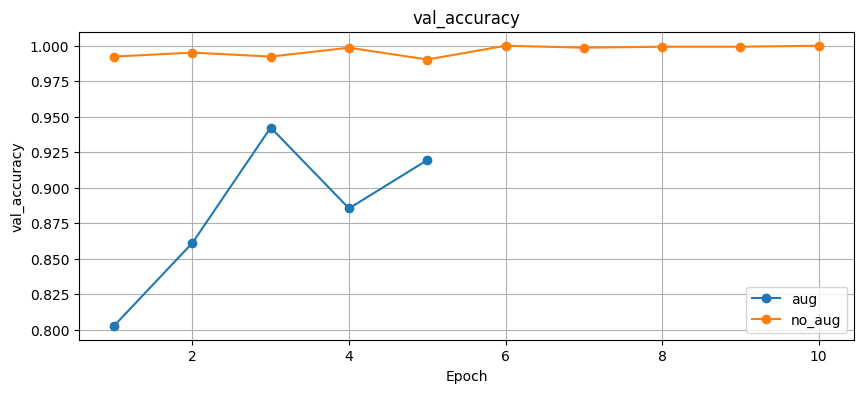

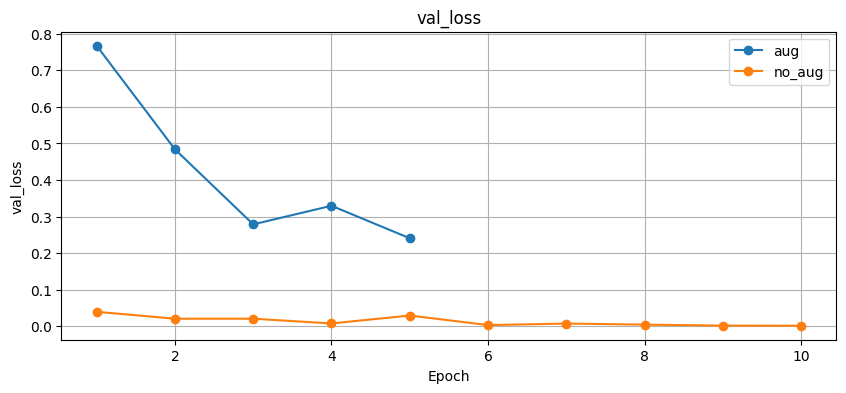

In [21]:
for metric in ["val_accuracy", "val_loss"]:
    plt.figure(figsize=(10,4))
    for run, g in df_all.groupby("run"):
        plt.plot(g["epoch"], g[metric], marker="o", label=run)
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()


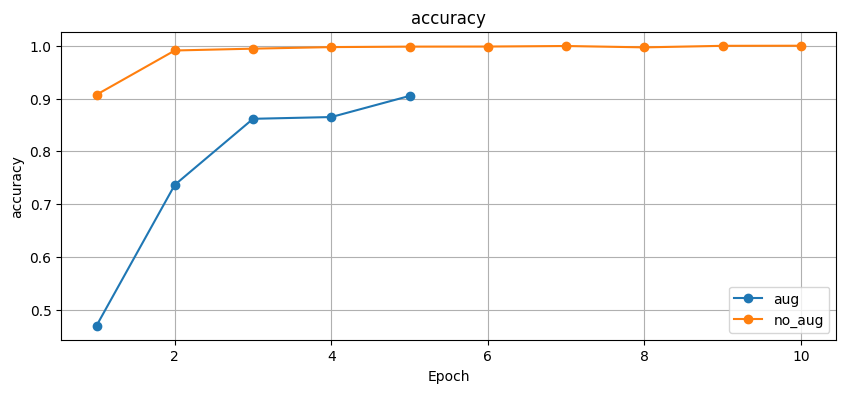

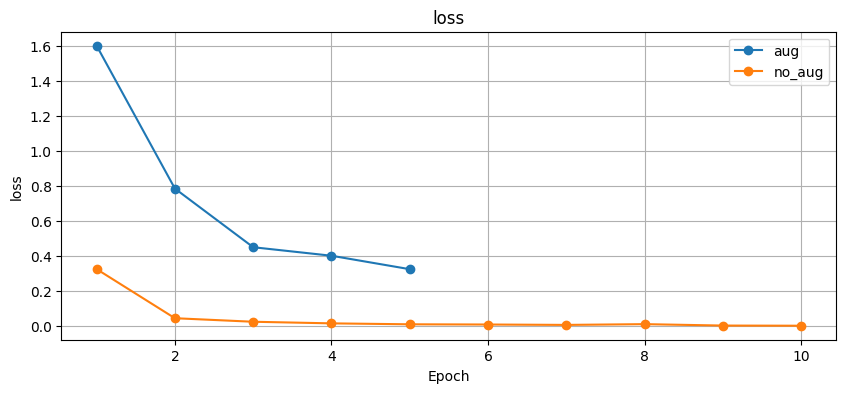

In [22]:
for metric in ["accuracy", "loss"]:
    plt.figure(figsize=(10,4))
    for run, g in df_all.groupby("run"):
        plt.plot(g["epoch"], g[metric], marker="o", label=run)
    plt.title(metric)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()


In [27]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(10,8))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()